# Levy Stable models of Stochastic Volatility

This tutorial demonstrates inference using the Levy [Stable](http://docs.pyro.ai/en/stable/distributions.html#stable) distribution through a motivating example of a non-Gaussian stochastic volatilty model.

Inference with stable distribution is tricky because the density `Stable.log_prob()` is not defined. In this tutorial we demonstrate two approaches to inference: (i) using the [poutine.reparam](http://docs.pyro.ai/en/latest/poutine.html#pyro.poutine.handlers.reparam) effect to transform models in to a tractable form, and (ii) using the likelihood-free loss [EnergyDistance](http://docs.pyro.ai/en/latest/inference_algos.html#pyro.infer.energy_distance.EnergyDistance) with SVI.


#### Summary

- [Stable.log_prob()](http://docs.pyro.ai/en/stable/distributions.html#stable) is undefined.
- Stable inference requires either reparameterization or a likelihood-free loss.
- Reparameterization:
    - The [poutine.reparam()](http://docs.pyro.ai/en/latest/poutine.html#pyro.poutine.handlers.reparam) handler can transform models using various [strategies](http://docs.pyro.ai/en/latest/infer.reparam.html).
    - The [StableReparam](http://docs.pyro.ai/en/latest/infer.reparam.html#pyro.infer.reparam.stable.StableReparam) strategy can be used for Stable distributions in SVI or HMC.
    - The [LatentStableReparam](http://docs.pyro.ai/en/latest/infer.reparam.html#pyro.infer.reparam.stable.LatentStableReparam) strategy is a little cheaper, but cannot be used for likelihoods.
    - The [DiscreteCosineReparam](http://docs.pyro.ai/en/latest/infer.reparam.html#pyro.infer.reparam.discrete_cosine.DiscreteCosine) strategy improves geometry in batched latent time series models.
- Likelihood-free loss with SVI:
    - The [EnergyDistance](http://docs.pyro.ai/en/latest/inference_algos.html#pyro.infer.energy_distance.EnergyDistance) loss allows stable distributions in the guide and in model likelihoods.

#### Table of contents

- [Daily S&P data](#data)
- [Fitting a single distribution to log returns](#fitting) using `EnergyDistance`
- [Modeling stochastic volatility](#modeling) using `poutine.reparam`

## Daily S&P 500 data <a class="anchor" id="data"></a>

The following daily closing prices for the S&P 500 were loaded from [Yahoo finance](https://finance.yahoo.com/quote/%5EGSPC/history/).

In [1]:
import math
import os
import torch
import pyro
import pyro.distributions as dist
from matplotlib import pyplot
from torch.distributions import constraints

from pyro import poutine
from pyro.contrib.examples.finance import load_snp500
from pyro.infer import EnergyDistance, Predictive, SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer.reparam import DiscreteCosineReparam, StableReparam
from pyro.optim import ClippedAdam
from pyro.ops.tensor_utils import convolve

%matplotlib inline
assert pyro.__version__.startswith('1.4.0')
pyro.enable_validation(True)
smoke_test = ('CI' in os.environ)

In [2]:
df = load_snp500()
dates = df.Date.to_numpy()
x = torch.tensor(df["Close"]).float()
x.shape

torch.Size([23116])

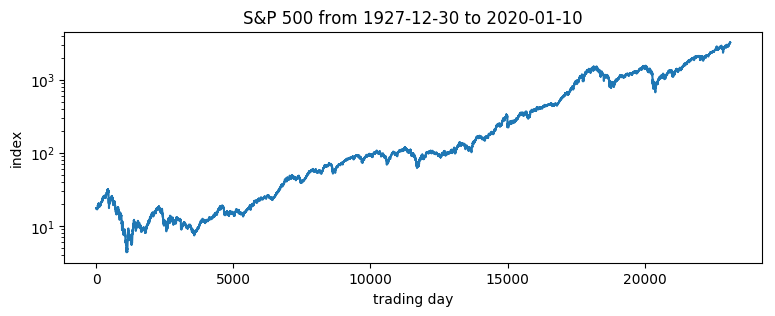

In [3]:
pyplot.figure(figsize=(9, 3))
pyplot.plot(x)
pyplot.yscale('log')
pyplot.ylabel("index")
pyplot.xlabel("trading day")
pyplot.title("S&P 500 from {} to {}".format(dates[0], dates[-1]));


Of interest are the log returns, i.e. the log ratio of price on two subsequent days.

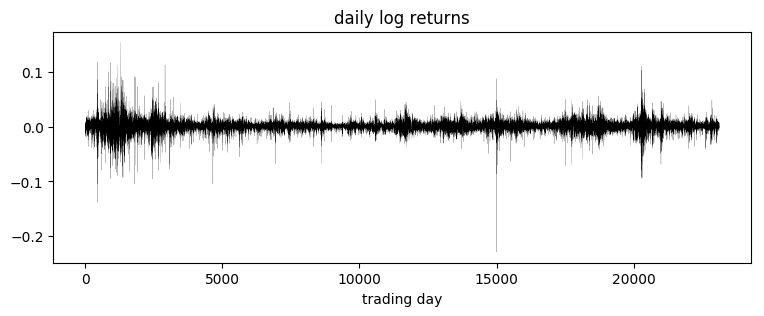

In [4]:
pyplot.figure(figsize=(9, 3))
r = (x[1:] / x[:-1]).log()
pyplot.plot(r, "k", lw=0.1)
pyplot.title("daily log returns")
pyplot.xlabel("trading day");

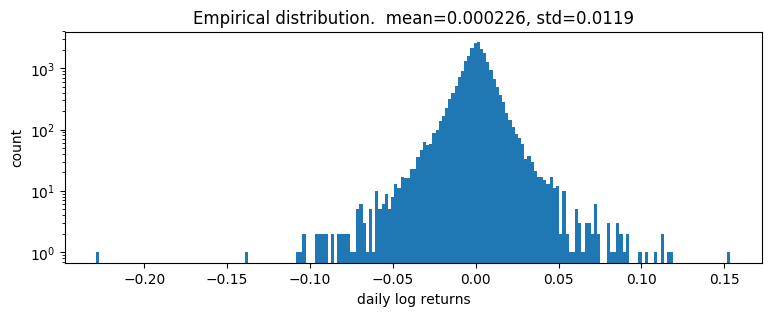

In [5]:
pyplot.figure(figsize=(9, 3))
pyplot.hist(r, bins=200)
pyplot.yscale('log')
pyplot.ylabel("count")
pyplot.xlabel("daily log returns")
pyplot.title("Empirical distribution.  mean={:0.3g}, std={:0.3g}".format(r.mean(), r.std()));

## Fitting a single distribution to log returns  <a class="anchor" id="fitting"></a>

Log returns appear to be heavy-tailed. First let's fit a single distribution to the returns. To fit the distribution, we'll use a likelihood free statistical inference algorithm [EnergyDistance](http://docs.pyro.ai/en/latest/inference_algos.html#pyro.infer.energy_distance.EnergyDistance), which matches fractional moments of observed data and can handle data with heavy tails.

In [6]:
def model():
    stability = pyro.param("stability", torch.tensor(1.9),
                           constraint=constraints.interval(0, 2))
    skew = 0.
    scale = pyro.param("scale", torch.tensor(0.1), constraint=constraints.positive)
    loc = pyro.param("loc", torch.tensor(0.))
    with pyro.plate("data", len(r)):
        return pyro.sample("r", dist.Stable(stability, skew, scale, loc), obs=r)

step 0 loss = 8.961664199829102
step 20 loss = 4.8506011962890625
step 40 loss = 1.5543489456176758
step 60 loss = 1.7787070274353027
step 80 loss = 1.4140945672988892
step 100 loss = 1.3671720027923584
step 120 loss = 1.287503719329834
step 140 loss = 1.2791334390640259
step 160 loss = 1.2810490131378174
step 180 loss = 1.2784368991851807
step 200 loss = 1.2823134660720825
--------------------
loc = 0.0003696
scale = 0.00872
stability = 1.977
CPU times: user 15.6 s, sys: 521 ms, total: 16.1 s
Wall time: 2.38 s


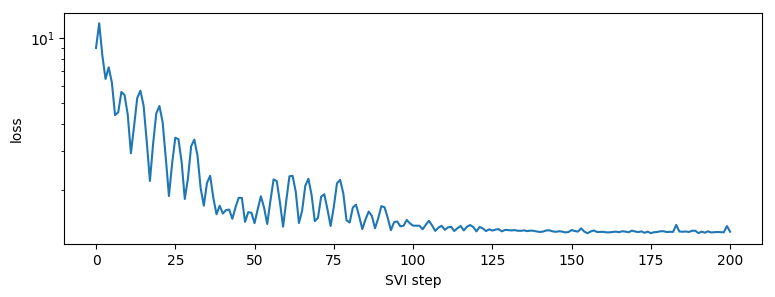

In [7]:
%%time
pyro.clear_param_store()
pyro.set_rng_seed(1234567890)
num_steps = 1 if smoke_test else 201
optim = ClippedAdam({"lr": 0.1, "lrd": 0.1 ** (1 / num_steps)})
svi = SVI(model, lambda: None, optim, EnergyDistance())
losses = []
for step in range(num_steps):
    loss = svi.step()
    losses.append(loss)
    if step % 20 == 0:
        print("step {} loss = {}".format(step, loss))

print("-" * 20)
pyplot.figure(figsize=(9, 3))
pyplot.plot(losses)
pyplot.yscale("log")
pyplot.ylabel("loss")
pyplot.xlabel("SVI step")
for name, value in sorted(pyro.get_param_store().items()):
    if value.numel() == 1:
        print("{} = {:0.4g}".format(name, value.squeeze().item()))

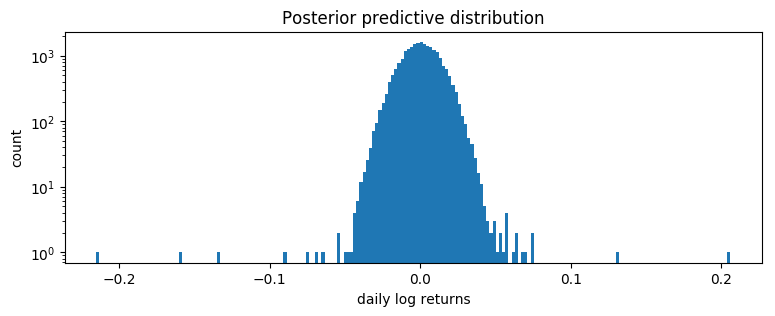

In [8]:
samples = poutine.uncondition(model)().detach()
pyplot.figure(figsize=(9, 3))
pyplot.hist(samples, bins=200)
pyplot.yscale("log")
pyplot.xlabel("daily log returns")
pyplot.ylabel("count")
pyplot.title("Posterior predictive distribution");


This is a poor fit, but that was to be expected since we are mixing all time steps together: we would expect this to be a scale-mixture of distributions (Normal, or Stable), but are modeling it as a single distribution (Stable in this case).

## Modeling stochastic volatility  <a class="anchor" id="modeling"></a>

We'll next fit a stochastic volatility model.
Let's begin with a constant volatility model where log price $p$ follows Brownian motion

$$
  \log p_t = \log p_{t-1} + w_t \sqrt h
$$

where $w_t$ is a sequence of standard white noise. We can rewrite this model in terms of the log returns $r_t=\log(p_t\,/\,p_{t-1})$:

$$
  r_t = w_t \sqrt h
$$

Now to account for [volatility clustering](https://en.wikipedia.org/wiki/Volatility_clustering) we can generalize to a stochastic volatility model where volatility $h$ depends on time $t$. Among the simplest such models is one where $h_t$ follows geometric Brownian motion

$$
  \log h_t = \log h_{t-1} + \sigma v_t
$$

where again $v_t$ is a sequence of standard white noise. The entire model thus consists of a geometric Brownian motion $h_t$ that determines the diffusion rate of another geometric Brownian motion $p_t$:

$$
  \log h_t = \log h_{t-1} + \sigma v_t \\
  \log p_t = \log p_{t-1} + w_t \sqrt h_t
$$

Usually $v_1$ and $w_t$ are both Gaussian. We will generalize to a Stable distribution for $w_t$, learning three parameters (stability, skew, and location), but still scaling by $\sqrt h_t$.

Our Pyro model will sample the increments $v_t$ and record the computation of $\log h_t$ via [pyro.deterministic](http://docs.pyro.ai/en/stable/primitives.html#pyro.deterministic). Note that there are many ways of implementing this model in Pyro, and geometry can vary depending on implementation. The following version seems to have good geometry, when combined with reparameterizers.

In [9]:
def model(data):
    # Note we avoid plates because we'll later reparameterize along the time axis using
    # DiscreteCosineReparam, breaking independence. This requires .unsqueeze()ing scalars.
    h_0 = pyro.sample("h_0", dist.Normal(0, 1)).unsqueeze(-1)
    sigma = pyro.sample("sigma", dist.LogNormal(0, 1)).unsqueeze(-1)
    v = pyro.sample("v", dist.Normal(0, 1).expand(data.shape).to_event(1))
    log_h = pyro.deterministic("log_h", h_0 + sigma * v.cumsum(dim=-1))
    sqrt_h = log_h.mul(0.5).exp().clamp(min=1e-8, max=1e8)

    # Observed log returns, assumed to be a Stable distribution scaled by sqrt(h).
    r_loc = pyro.sample("r_loc", dist.Normal(0, 1e-2)).unsqueeze(-1)
    r_skew = pyro.sample("r_skew", dist.Uniform(-1, 1)).unsqueeze(-1)
    r_stability = pyro.sample("r_stability", dist.Uniform(0, 2)).unsqueeze(-1)
    pyro.sample("r", dist.Stable(r_stability, r_skew, sqrt_h, r_loc * sqrt_h).to_event(1),
                obs=data)

We use two reparameterizers: [StableReparam](http://docs.pyro.ai/en/latest/infer.reparam.html#pyro.infer.reparam.stable.StableReparam) to handle the `Stable` likelihood (since `Stable.log_prob()` is undefined), and [DiscreteCosineReparam](http://docs.pyro.ai/en/latest/infer.reparam.html#pyro.infer.reparam.discrete_cosine.DiscreteCosineReparam) to improve geometry of the latent Gaussian process for `v`. We'll then use `reparam_model` for both inference and prediction.

In [10]:
reparam_model = poutine.reparam(model, {"v": DiscreteCosineReparam(),
                                        "r": StableReparam()})

step 0 loss = 80.7915
step 50 loss = 2.49764
step 100 loss = 6.18623
step 150 loss = -1.42891
step 200 loss = -2.48601
step 250 loss = -2.75234
step 300 loss = -2.80716
step 350 loss = -2.64854
step 400 loss = -2.93349
step 450 loss = -2.90964
step 500 loss = -2.93564
step 550 loss = -2.98376
step 600 loss = -3.01648
step 650 loss = -3.01208
step 700 loss = -3.04329
step 750 loss = -3.03045
step 800 loss = -3.04258
step 850 loss = -3.06856
step 900 loss = -3.05272
step 950 loss = -3.06414
step 1000 loss = -3.06487
--------------------
h_0 = 0.3713 ± 0.01079
r_loc = 0.05134 ± 0.002976
r_skew = 0.0001597 ± 0.0002002
r_stability = 1.92 ± 0.001772
sigma = 0.2373 ± 0.000313
CPU times: user 38.1 s, sys: 6.95 s, total: 45.1 s
Wall time: 45.1 s


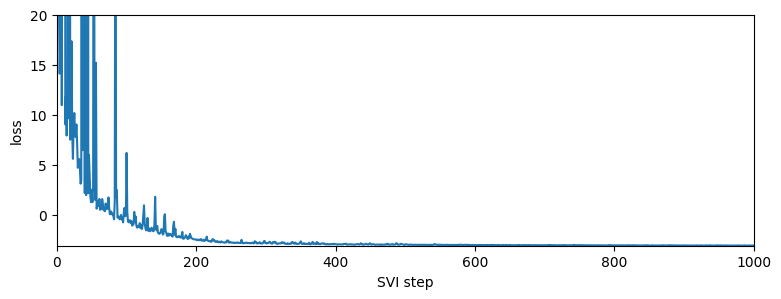

In [11]:
%%time
pyro.clear_param_store()
pyro.set_rng_seed(1234567890)
num_steps = 1 if smoke_test else 1001
optim = ClippedAdam({"lr": 0.05, "betas": (0.9, 0.99), "lrd": 0.1 ** (1 / num_steps)})
guide = AutoDiagonalNormal(reparam_model)
svi = SVI(reparam_model, guide, optim, Trace_ELBO())
losses = []
for step in range(num_steps):
    loss = svi.step(r) / len(r)
    losses.append(loss)
    if step % 50 == 0:
        median = guide.median()
        print("step {} loss = {:0.6g}".format(step, loss))

print("-" * 20)
for name, (lb, ub) in sorted(guide.quantiles([0.325, 0.675]).items()):
    if lb.numel() == 1:
        lb = lb.detach().squeeze().item()
        ub = ub.detach().squeeze().item()
        print("{} = {:0.4g} ± {:0.4g}".format(name, (lb + ub) / 2, (ub - lb) / 2))

pyplot.figure(figsize=(9, 3))
pyplot.plot(losses)
pyplot.ylabel("loss")
pyplot.xlabel("SVI step")
pyplot.xlim(0, len(losses))
pyplot.ylim(min(losses), 20)

It appears the log returns exhibit very little skew, but exhibit a stability parameter slightly but significantly less than 2. This contrasts the usual Normal model corresponding to a Stable distribution with skew=0 and stability=2. We can now visualize the estimated volatility:

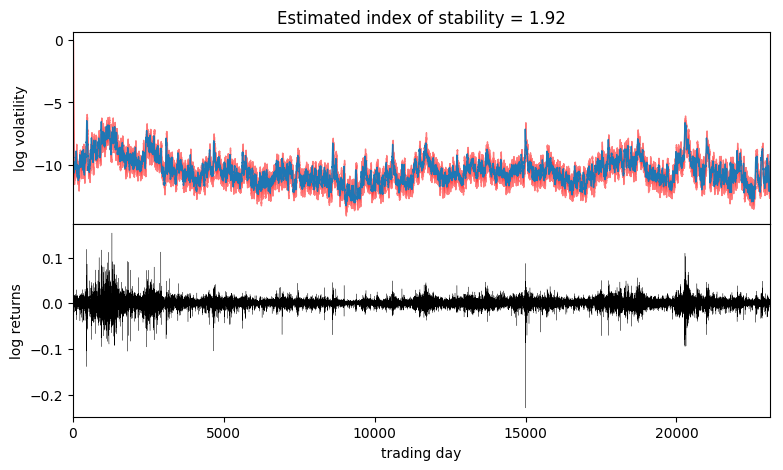

In [12]:
fig, axes = pyplot.subplots(2, figsize=(9, 5), sharex=True)
pyplot.subplots_adjust(hspace=0)
axes[1].plot(r, "k", lw=0.2)
axes[1].set_ylabel("log returns")
axes[1].set_xlim(0, len(r))

# We will pull out median log returns using the autoguide's .median() and poutines.
with torch.no_grad():
    pred = Predictive(reparam_model, guide=guide, num_samples=20, parallel=True)(r)
log_h = pred["log_h"]
axes[0].plot(log_h.median(0).values, lw=1)
axes[0].fill_between(torch.arange(len(log_h[0])),
                     log_h.kthvalue(2, dim=0).values,
                     log_h.kthvalue(18, dim=0).values,
                     color='red', alpha=0.5)
axes[0].set_ylabel("log volatility")

stability = pred["r_stability"].median(0).values.item()
axes[0].set_title("Estimated index of stability = {:0.4g}".format(stability))
axes[1].set_xlabel("trading day");

Observe that volatility roughly follows areas of large absolute log returns. Note that the uncertainty is underestimated, since we have used an approximate `AutoDiagonalNormal` guide. For more precise uncertainty estimates, one could use [HMC](http://docs.pyro.ai/en/stable/mcmc.html#hmc) or [NUTS](http://docs.pyro.ai/en/stable/mcmc.html#nuts) inference.